In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Literal, Optional

import numpy as np
import pandas as pd
from typing import List
from pathlib import Path

SeizureTimeAxis = Literal["clinical", "video", "default"]
DATASTRUCT_ROOT = Path(r"E:\Speciale - Results\Datastruct")
MAIN_DATA_ROOT  = Path(r"E:\Speciale - Results")
STUDY2_ROOT     = Path(MAIN_DATA_ROOT / "study2")

PATH_REC = DATASTRUCT_ROOT / "recordings_index.csv"
PATH_SEIZURE = DATASTRUCT_ROOT / "seizure_events.csv"
PATH_WINDOW_QUALITY = STUDY2_ROOT / "window_quality_baseline_vs_seizure.csv"

# hvor du evt. vil gemme mellem- og slutresultater til Study4
STUDY4_OUT = Path(MAIN_DATA_ROOT  / "study4")
STUDY4_OUT.mkdir(parents=True, exist_ok=True)

In [2]:
@dataclass(frozen=True)
class Study4Paths:
    recordings_index: Path
    seizure_events: Path
    window_quality: Path
    out_dir: Path


def load_windows_df(paths: Study4Paths) -> pd.DataFrame:
    df_rec = pd.read_csv(paths.recordings_index)
    df_seiz = pd.read_csv(paths.seizure_events)
    df_winq = pd.read_csv(paths.window_quality)

    # Merge: window_quality × recordings_index
    df = df_winq.merge(
        df_rec,
        on=["recording_uid", "patient_id", "recording_id"],
        how="left",
        validate="m:1",
    )

    # Merge: add seizures (will duplicate windows per seizure)
    df = df.merge(
        df_seiz,
        on=["recording_uid", "patient_id", "recording_id"],
        how="left",
        suffixes=("", "_seiz"),
        validate="m:m",
    )
    return df

# def load_windows_df(paths: List[Path] = [PATH_REC, PATH_SEIZURE, PATH_WINDOW_QUALITY]) -> pd.DataFrame:
#     df_rec = pd.read_csv(paths[0])
#     df_seiz = pd.read_csv(paths[1])
#     df_winq = pd.read_csv(paths[2])

#     # Merge recordings with seizure events
#     df = pd.merge(df_winq, df_rec, on=['recording_uid', 'patient_id', 'recording_id'], how='left')

#     # Merge with seizure events to get seizure info
#     df = pd.merge(df, df_seiz, on=['recording_uid', 'patient_id', 'recording_id'], how='left', suffixes=('', '_seiz'))

#     # # Add is_acceptable is_acceptable = ~(is_flatline | is_noiseburst | is_clipping)
#     # df['is_acceptable'] = ~(df['is_flatline'] | df['is_noiseburst'] | df['is_clipping'])

#     # # Window overlaps seizure event: window_overlaps_seizure = ((win_abs_end   > absolute_start_clinical) &(win_abs_start < absolute_end_clinical))
#     # df['window_overlaps_seizure'] = (
#     #     (df['win_end_s'] > df['t0']) &
#     #     (df['win_start_s'] < df['t1'])
#     # )

#     return df

# if __name__ == "__main__":
#     windows_df = load_windows_df()
#     print(windows_df.head())

# windows_df.columns.tolist()

In [ ]:
def add_is_acceptable(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in ["is_flatline", "is_noiseburst", "is_clipping"]:
        if col not in out.columns:
            raise KeyError(f"Missing required column: {col}")
        out[col] = out[col].astype(bool)
    out["is_acceptable"] = ~(out["is_flatline"] | out["is_noiseburst"] | out["is_clipping"])
    return out


def add_window_absolute_times(
    df: pd.DataFrame,
    *,
    recording_start_col: str = "recording_start",
    win_start_s_col: str = "win_start_s",
    win_end_s_col: str = "win_end_s",
) -> pd.DataFrame:
    out = df.copy()
    if recording_start_col not in out.columns:
        raise KeyError(f"Missing {recording_start_col}")
    if win_start_s_col not in out.columns or win_end_s_col not in out.columns:
        raise KeyError(f"Missing {win_start_s_col} / {win_end_s_col}")

    # Robust parsing (works for ISO strings; coerces bad rows to NaT)
    out[recording_start_col] = pd.to_datetime(out[recording_start_col], errors="coerce")

    # Ensure numeric seconds
    out[win_start_s_col] = pd.to_numeric(out[win_start_s_col], errors="coerce")
    out[win_end_s_col] = pd.to_numeric(out[win_end_s_col], errors="coerce")

    # If recording_start is NaT, abs times become NaT -> safe later
    out["win_abs_start"] = out[recording_start_col] + pd.to_timedelta(out[win_start_s_col], unit="s")
    out["win_abs_end"] = out[recording_start_col] + pd.to_timedelta(out[win_end_s_col], unit="s")
    return out


def _pick_seizure_cols(axis: SeizureTimeAxis, df_cols: set[str]) -> tuple[str, str]:
    if axis == "clinical":
        return "absolute_start_clinical", "absolute_end_clinical"
    if axis == "video":
        return "absolute_start_video", "absolute_end_video"
    # default: prefer clinical if available, else fallback
    if "absolute_start_clinical" in df_cols and "absolute_end_clinical" in df_cols:
        return "absolute_start_clinical", "absolute_end_clinical"
    return "absolute_start", "absolute_end"


def add_seizure_overlap_flag(
    df: pd.DataFrame,
    *,
    axis: SeizureTimeAxis = "clinical",
) -> pd.DataFrame:
    out = df.copy()
    if "win_abs_start" not in out.columns or "win_abs_end" not in out.columns:
        raise KeyError("Need win_abs_start/win_abs_end (run add_window_absolute_times first).")

    start_col, end_col = _pick_seizure_cols(axis, set(out.columns))
    if start_col not in out.columns or end_col not in out.columns:
        raise KeyError(f"Missing seizure time cols: {start_col}, {end_col}")

    out[start_col] = pd.to_datetime(out[start_col], errors="coerce")
    out[end_col] = pd.to_datetime(out[end_col], errors="coerce")

    has_seiz = out[start_col].notna() & out[end_col].notna()
    has_win = out["win_abs_start"].notna() & out["win_abs_end"].notna()

    overlap_row = np.zeros(len(out), dtype=bool)
    m = (has_seiz & has_win).values
    overlap_row[m] = (
        (out.loc[m, "win_abs_end"].values > out.loc[m, start_col].values)
        & (out.loc[m, "win_abs_start"].values < out.loc[m, end_col].values)
    )
    out["window_overlaps_seizure_row"] = overlap_row

    # Collapse to UNIQUE window-level flag (because windows are duplicated across seizures)
    window_key = ["recording_uid", "window_idx"] if "window_idx" in out.columns else ["recording_uid", "win_abs_start", "win_abs_end"]
    any_overlap = (
        out.groupby(window_key, dropna=False)["window_overlaps_seizure_row"]
        .any()
        .rename("window_overlaps_seizure")
        .reset_index()
    )

    out = out.drop(columns=["window_overlaps_seizure_row"])
    out = out.merge(any_overlap, on=window_key, how="left")
    out["window_overlaps_seizure"] = out["window_overlaps_seizure"].fillna(False).astype(bool)
    return out


# -------------------------
# Summaries
# -------------------------
def _unique_windows(df: pd.DataFrame) -> pd.DataFrame:
    uniq_cols = ["recording_uid", "window_idx"] if "window_idx" in df.columns else ["recording_uid", "win_start_s", "win_end_s"]
    return df.drop_duplicates(subset=uniq_cols).copy()


def summarise_retention_overall(df: pd.DataFrame) -> pd.DataFrame:
    required = ["recording_uid", "is_acceptable", "window_overlaps_seizure", "win_start_s", "win_end_s"]
    for c in required:
        if c not in df.columns:
            raise KeyError(f"Missing {c}")

    out = _unique_windows(df)
    out["win_dur_s"] = (out["win_end_s"] - out["win_start_s"]).astype(float)

    def block(g: pd.DataFrame, prefix: str) -> dict:
        total_s = float(g["win_dur_s"].sum())
        kept_s = float(g.loc[g["is_acceptable"], "win_dur_s"].sum())
        total_n = int(len(g))
        kept_n = int(g["is_acceptable"].sum())
        return {
            f"{prefix}_total_windows": total_n,
            f"{prefix}_kept_windows": kept_n,
            f"{prefix}_retention_frac_windows": (kept_n / total_n) if total_n else np.nan,
            f"{prefix}_total_s": total_s,
            f"{prefix}_kept_s": kept_s,
            f"{prefix}_retention_frac_s": (kept_s / total_s) if total_s else np.nan,
        }

    rows = []
    for rid, g in out.groupby("recording_uid", sort=False):
        d = {"recording_uid": rid}
        d.update(block(g, "all"))
        d.update(block(g[g["window_overlaps_seizure"]], "seiz"))
        d.update(block(g[~g["window_overlaps_seizure"]], "base"))
        rows.append(d)

    return pd.DataFrame(rows)


def summarise_retention_by_seizure(df: pd.DataFrame, *, axis: SeizureTimeAxis = "clinical") -> pd.DataFrame:
    out = df.copy()
    start_col, end_col = _pick_seizure_cols(axis, set(out.columns))

    need = ["recording_uid", "seizure_id", "is_acceptable", "win_abs_start", "win_abs_end", start_col, end_col]
    for c in need:
        if c not in out.columns:
            raise KeyError(f"Missing {c}")

    out[start_col] = pd.to_datetime(out[start_col], errors="coerce")
    out[end_col] = pd.to_datetime(out[end_col], errors="coerce")

    out = out[out["seizure_id"].notna() & out[start_col].notna() & out[end_col].notna()].copy()
    out = out[out["win_abs_start"].notna() & out["win_abs_end"].notna()].copy()

    # Unique windows within seizure_id (because input is already duplicated per seizure)
    uniq_cols = ["recording_uid", "seizure_id", "window_idx"] if "window_idx" in out.columns else ["recording_uid", "seizure_id", "win_abs_start", "win_abs_end"]
    out = out.drop_duplicates(subset=uniq_cols)

    # Keep only windows overlapping THIS seizure interval
    ov = (out["win_abs_end"] > out[start_col]) & (out["win_abs_start"] < out[end_col])
    out = out[ov].copy()

    out["win_dur_s"] = (out["win_abs_end"] - out["win_abs_start"]).dt.total_seconds().astype(float)

    rows = []
    for (rid, sid), g in out.groupby(["recording_uid", "seizure_id"], sort=False):
        total_s = float(g["win_dur_s"].sum())
        kept_s = float(g.loc[g["is_acceptable"], "win_dur_s"].sum())
        rows.append({
            "recording_uid": rid,
            "seizure_id": sid,
            "seiz_total_windows": int(len(g)),
            "seiz_kept_windows": int(g["is_acceptable"].sum()),
            "seiz_retention_frac_windows": float(g["is_acceptable"].mean()) if len(g) else np.nan,
            "seiz_total_s": total_s,
            "seiz_kept_s": kept_s,
            "seiz_retention_frac_s": (kept_s / total_s) if total_s else np.nan,
        })
    return pd.DataFrame(rows)

def build_recording_uid_map_from_recordings_index(df_rec: pd.DataFrame) -> pd.DataFrame:
    """
    Builds mapping between numeric recording_uid and human-readable uid_str.
    Expects df_rec = recordings_index.csv loaded as DataFrame.
    """
    uid_map = df_rec.loc[:, ["recording_uid", "patient_id", "enrollment_id", "recording_id"]].copy()

    uid_map["recording_uid"] = pd.to_numeric(uid_map["recording_uid"], errors="raise").astype("int64")
    uid_map["patient_id"] = pd.to_numeric(uid_map["patient_id"], errors="raise").astype("int64")
    uid_map["recording_id"] = pd.to_numeric(uid_map["recording_id"], errors="raise").astype("int64")

    # enrollment_id is often "", "a", "b", "c" (string). Keep as string.
    uid_map["enrollment_id"] = uid_map["enrollment_id"].fillna("").astype(str)

    uid_map["uid_str"] = (
        "P"
        + uid_map["patient_id"].astype(str).str.zfill(2)
        + uid_map["enrollment_id"]
        + "_R"
        + uid_map["recording_id"].astype(str).str.zfill(2)
    )

    # sanity: one uid_str per recording_uid
    uid_map = uid_map.drop_duplicates(subset=["recording_uid"])
    if uid_map["uid_str"].duplicated().any():
        # If this triggers, you have collisions in your formatting assumptions.
        dup = uid_map[uid_map["uid_str"].duplicated(keep=False)].sort_values("uid_str")
        raise ValueError(f"uid_str collisions detected:\n{dup}")

    return uid_map



# -------------------------
# Masks for Study 5
# -------------------------
def build_quality_mask(df: pd.DataFrame) -> pd.DataFrame:
    """
    Output: one row per unique window with boolean acceptability, ready for Study 5 joins.
    """
    need = ["recording_uid", "window_idx", "win_start_s", "win_end_s", "is_acceptable"]
    for c in need:
        if c not in df.columns:
            raise KeyError(f"Missing {c}")

    out = _unique_windows(df)
    return out[["recording_uid", "window_idx", "win_start_s", "win_end_s", "is_acceptable"]].copy()


def run_study4(paths: Study4Paths, *, axis: SeizureTimeAxis = "clinical") -> dict[str, pd.DataFrame]:
    paths.out_dir.mkdir(parents=True, exist_ok=True)

    df = load_windows_df(paths)  # windows+rec+seiz
    df = add_is_acceptable(df)
    df = add_window_absolute_times(df)
    df = add_seizure_overlap_flag(df, axis=axis)

    # NEW: add uid_str column for human-readable joins/plots
    df_rec = pd.read_csv(paths.recordings_index)
    uid_map = build_recording_uid_map_from_recordings_index(df_rec)
    df = df.merge(uid_map[["recording_uid", "uid_str"]], on="recording_uid", how="left", validate="m:1")

    rec_summary = summarise_retention_overall(df)
    seiz_summary = summarise_retention_by_seizure(df, axis=axis)
    mask = build_quality_mask(df)

    rec_summary.to_csv(paths.out_dir / "study4_retention_by_recording.csv", index=False)
    seiz_summary.to_csv(paths.out_dir / "study4_retention_by_seizure.csv", index=False)
    mask.to_parquet(paths.out_dir / "study4_quality_mask.parquet", index=False)

    # Save mapping too (super useful for Study3/Study5 joins)
    uid_map.to_csv(paths.out_dir / "recording_uid_map.csv", index=False)

    df.to_parquet(paths.out_dir / "study4_windows_merged_processed.parquet", index=False)

    return {
        "windows_df": df,
        "retention_by_recording": rec_summary,
        "retention_by_seizure": seiz_summary,
        "quality_mask": mask,
        "uid_map": uid_map,
    }



if __name__ == "__main__":
    PATHS = Study4Paths(
        recordings_index=PATH_REC,
        seizure_events=PATH_SEIZURE,
        window_quality=PATH_WINDOW_QUALITY,
        out_dir=STUDY4_OUT,
    )
    out = run_study4(PATHS, axis="clinical")
    print(out["retention_by_recording"].head())
    print(out["retention_by_seizure"].head())
    print(out["quality_mask"].head())

   recording_uid  all_total_windows  all_kept_windows  \
0              0              19061             19036   
1              1              14598             14584   
2              2               6364              6356   
3              3              17074             17073   
4              4              16853             16845   

   all_retention_frac_windows  all_total_s  all_kept_s  all_retention_frac_s  \
0                    0.998688     190610.0    190360.0              0.998688   
1                    0.999041     145980.0    145840.0              0.999041   
2                    0.998743      63640.0     63560.0              0.998743   
3                    0.999941     170740.0    170730.0              0.999941   
4                    0.999525     168530.0    168450.0              0.999525   

   seiz_total_windows  seiz_kept_windows  seiz_retention_frac_windows  \
0                   5                  5                          1.0   
1                  15         

In [4]:
# Show the available keys and the columns of each DataFrame in `out`
for name, df in out.items():
    print(f"{name}:")
    print(df.columns.tolist())
    print()

windows_df:
['recording_uid', 'patient_id', 'recording_id', 'window_idx', 'win_start_s', 'win_end_s', 'context', 'std', 'range', 'diff_abs_med', 'is_flatline', 'is_noiseburst', 'is_clipping', 'enrollment_id', 'tdms_path', 'annotation_source', 'recording_start', 'recording_end', 'rec_duration_s', 'fs', 'trim_start_s', 'trim_end_s', 'enrollment_id_seiz', 'seizure_id', 't0', 't1', 'duration_s', 'absolute_start', 'absolute_end', 'trim_start_s_seiz', 'trim_end_s_seiz', 't0_trim', 't1_trim', 't0_video', 't1_video', 'absolute_start_video', 'absolute_end_video', 't0_video_trim', 't1_video_trim', 't0_clinical', 't1_clinical', 'absolute_start_clinical', 'absolute_end_clinical', 't0_clinical_trim', 't1_clinical_trim', 'is_acceptable', 'win_abs_start', 'win_abs_end', 'window_overlaps_seizure', 'uid_str']

retention_by_recording:
['recording_uid', 'all_total_windows', 'all_kept_windows', 'all_retention_frac_windows', 'all_total_s', 'all_kept_s', 'all_retention_frac_s', 'seiz_total_windows', 'seiz_k

In [5]:
# Print all 'recording_uid' values in the dictionary 'out'
for name, df in out.items():
    if 'recording_uid' in df.columns:
        print(f"{name} recording_uid values:")
        print(df['recording_uid'].unique())
        print()

windows_df recording_uid values:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]

retention_by_recording recording_uid values:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]

retention_by_seizure recording_uid values:
[ 0  1  2  3  4  5  6  7  9 10 11 13 14 16 17 18 19 20 21 22 24 26 27 28
 29 30 31 32 33 36 38 40 41 42 44 45 47 48 49 50 53 54 58 60 61 63 65 66
 67 68 69 70 71]

quality_mask recording_uid values:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]

uid_map recording

In [6]:
def flag_summary_table(df4: pd.DataFrame) -> pd.DataFrame:
    w = df4.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()

    def summarize(mask, name):
        g = w.loc[mask].copy()
        n = len(g)
        return pd.Series({
            "group": name,
            "n_windows": n,
            "frac_flatline": g["is_flatline"].mean(),
            "frac_noiseburst": g["is_noiseburst"].mean(),
            "frac_clipping": g["is_clipping"].mean(),
            "frac_unacceptable": (~g["is_acceptable"]).mean(),
        })

    tab = pd.concat([
        summarize(np.ones(len(w), dtype=bool), "all"),
        summarize(w["window_overlaps_seizure"].values, "seizure-overlap"),
        summarize((~w["window_overlaps_seizure"]).values, "baseline"),
    ], axis=1).T

    return tab

df_flags = flag_summary_table(out["windows_df"])
display(df_flags)
df_flags.to_csv(PATHS.out_dir / "study4_flag_frequencies.csv", index=False)


,group,n_windows,frac_flatline,frac_noiseburst,frac_clipping,frac_unacceptable
0,all,1142228,0.0,0.008412,0.000037,0.008415
1,seizure-overlap,1140,0.0,0.023684,0.0,0.023684
2,baseline,1141088,0.0,0.008396,0.000037,0.0084


In [7]:
def retention_overview(df_ret_rec: pd.DataFrame) -> pd.DataFrame:
    cols = [
        "all_retention_frac_s",
        "base_retention_frac_s",
        "seiz_retention_frac_s",
    ]
    return df_ret_rec[cols].describe(percentiles=[0.05, 0.5, 0.95]).T

display(retention_overview(out["retention_by_recording"]))


,count,mean,std,min,5%,50%,95%,max
all_retention_frac_s,72.0,0.992058,0.014098,0.932422,0.954546,0.998714,0.999943,1.0
base_retention_frac_s,72.0,0.992072,0.014098,0.932385,0.954523,0.998710,0.999943,1.0
seiz_retention_frac_s,53.0,0.985329,0.043428,0.777778,0.917706,1.000000,1.000000,1.0


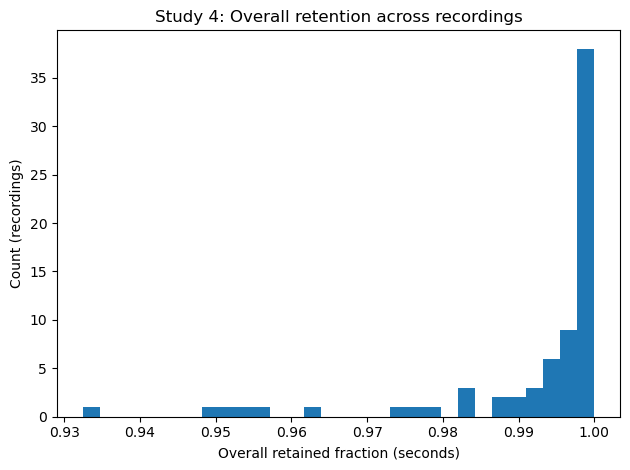

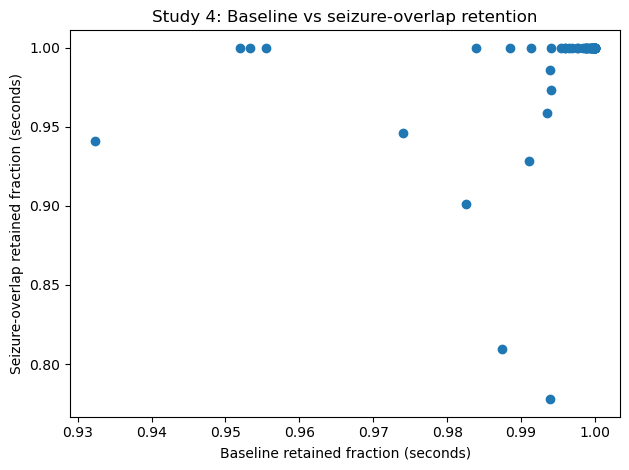

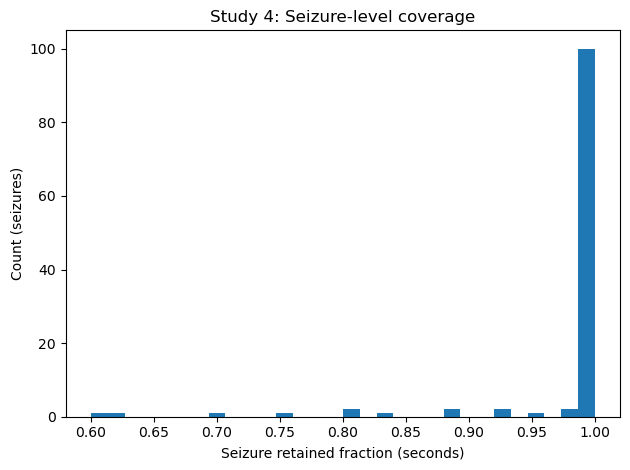

In [8]:
import matplotlib.pyplot as plt

df_ret_rec = out["retention_by_recording"]
df_ret_seiz = out["retention_by_seizure"]

# A: retention distribution
plt.figure()
plt.hist(df_ret_rec["all_retention_frac_s"].dropna(), bins=30)
plt.xlabel("Overall retained fraction (seconds)")
plt.ylabel("Count (recordings)")
plt.title("Study 4: Overall retention across recordings")
plt.tight_layout()

# B: baseline vs seizure retention scatter
plt.figure()
plt.scatter(df_ret_rec["base_retention_frac_s"], df_ret_rec["seiz_retention_frac_s"])
plt.xlabel("Baseline retained fraction (seconds)")
plt.ylabel("Seizure-overlap retained fraction (seconds)")
plt.title("Study 4: Baseline vs seizure-overlap retention")
plt.tight_layout()

# C: seizure-level retained fraction
plt.figure()
plt.hist(df_ret_seiz["seiz_retention_frac_s"].dropna(), bins=30)
plt.xlabel("Seizure retained fraction (seconds)")
plt.ylabel("Count (seizures)")
plt.title("Study 4: Seizure-level coverage")
plt.tight_layout()

plt.show()


In [9]:
plt.savefig(PATHS.out_dir / "study4_retention_hist.png", dpi=200)


<Figure size 640x480 with 0 Axes>

In [10]:
from dataclasses import dataclass
import numpy as np
import pandas as pd

@dataclass(frozen=True)
class SqiVariant:
    name: str
    # which base flags to exclude (always available)
    use_flags: bool = True
    # numeric thresholds (optional)
    std_max: float | None = None
    range_max: float | None = None
    diff_abs_med_max: float | None = None


def compute_thresholds_from_baseline(
    df4: pd.DataFrame,
    *,
    q_std: float = 0.995,
    q_range: float = 0.995,
    q_diff: float = 0.995,
) -> dict[str, float]:
    """
    Compute thresholds on baseline windows only (recommended),
    so seizures don't inflate your noise thresholds.
    """
    w = df4.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()
    base = w[~w["window_overlaps_seizure"]].copy()

    thr = {
        "std_max": float(base["std"].quantile(q_std)),
        "range_max": float(base["range"].quantile(q_range)),
        "diff_abs_med_max": float(base["diff_abs_med"].quantile(q_diff)),
    }
    return thr


def add_sqi_variants(df4: pd.DataFrame, variants: list[SqiVariant]) -> pd.DataFrame:
    out = df4.copy()

    # ensure bool flags exist
    for col in ["is_flatline", "is_noiseburst", "is_clipping"]:
        out[col] = out[col].astype(bool)

    for v in variants:
        ok = pd.Series(True, index=out.index)

        if v.use_flags:
            ok &= ~(out["is_flatline"] | out["is_noiseburst"] | out["is_clipping"])

        if v.std_max is not None:
            ok &= out["std"] <= v.std_max
        if v.range_max is not None:
            ok &= out["range"] <= v.range_max
        if v.diff_abs_med_max is not None:
            ok &= out["diff_abs_med"] <= v.diff_abs_med_max

        out[f"is_acceptable_{v.name}"] = ok.astype(bool)

    return out


In [11]:
def summarise_retention_overall_for_accept_col(df4: pd.DataFrame, accept_col: str) -> pd.DataFrame:
    req = ["recording_uid", "window_overlaps_seizure", "win_start_s", "win_end_s", accept_col]
    for c in req:
        if c not in df4.columns:
            raise KeyError(f"Missing {c}")

    w = df4.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()
    w["win_dur_s"] = (w["win_end_s"] - w["win_start_s"]).astype(float)
    w["is_acc"] = w[accept_col].astype(bool)

    def block(g: pd.DataFrame, prefix: str) -> dict:
        total_s = float(g["win_dur_s"].sum())
        kept_s = float(g.loc[g["is_acc"], "win_dur_s"].sum())
        total_n = int(len(g))
        kept_n = int(g["is_acc"].sum())
        return {
            f"{prefix}_ret_s": kept_s / total_s if total_s else np.nan,
            f"{prefix}_ret_w": kept_n / total_n if total_n else np.nan,
            f"{prefix}_n_w": total_n,
        }

    rows = []
    for rid, g in w.groupby("recording_uid", sort=False):
        d = {"recording_uid": rid, "variant": accept_col.replace("is_acceptable_", "")}
        d.update(block(g, "all"))
        d.update(block(g[g["window_overlaps_seizure"]], "seiz"))
        d.update(block(g[~g["window_overlaps_seizure"]], "base"))
        rows.append(d)

    return pd.DataFrame(rows)


In [12]:
df4 = out["windows_df"]  # fra run_study4

thr = compute_thresholds_from_baseline(df4, q_std=0.995, q_range=0.995, q_diff=0.995)

variants = [
    SqiVariant(name="v0_flags_only", use_flags=True),
    SqiVariant(name="v1_flags_p995_std", use_flags=True, std_max=thr["std_max"]),
    SqiVariant(name="v2_flags_p995_std_range", use_flags=True, std_max=thr["std_max"], range_max=thr["range_max"]),
    SqiVariant(name="v3_flags_p995_all3", use_flags=True, std_max=thr["std_max"], range_max=thr["range_max"], diff_abs_med_max=thr["diff_abs_med_max"]),
]

df4v = add_sqi_variants(df4, variants)

summaries = []
for v in variants:
    summaries.append(summarise_retention_overall_for_accept_col(df4v, f"is_acceptable_{v.name}"))

df_ret_sens = pd.concat(summaries, ignore_index=True)

# Quick overview (median retention per variant)
overview = (
    df_ret_sens.groupby("variant")[["all_ret_s", "base_ret_s", "seiz_ret_s"]]
    .median()
    .sort_values("all_ret_s", ascending=False)
)
display(overview)


,all_ret_s,base_ret_s,seiz_ret_s
variant,,,
v0_flags_only,0.998714,0.998710,1.0
v1_flags_p995_std,0.996028,0.996021,1.0
v2_flags_p995_std_range,0.995357,0.995357,1.0
v3_flags_p995_all3,0.993605,0.993689,1.0


In [13]:
def map_errors_to_windows(
    df_errors: pd.DataFrame,
    df4_windows: pd.DataFrame,
    *,
    time_col: str = "t_s",
    accept_col: str = "is_acceptable",
) -> pd.DataFrame:
    need_e = {"recording_uid", time_col, "error_type", "algo_id"}
    miss = need_e - set(df_errors.columns)
    if miss:
        raise KeyError(f"df_errors missing: {miss}")

    # unique windows
    w = df4_windows.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()
    need_w = {"recording_uid", "window_idx", "win_start_s", "win_end_s", accept_col}
    missw = need_w - set(w.columns)
    if missw:
        raise KeyError(f"df4_windows missing: {missw}")

    # --- normalize dtypes ---
    e = df_errors.copy()
    e["recording_uid"] = pd.to_numeric(e["recording_uid"], errors="coerce")
    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    e = e.dropna(subset=["recording_uid"])
    w = w.dropna(subset=["recording_uid"])
    e["recording_uid"] = e["recording_uid"].astype("int64")
    w["recording_uid"] = w["recording_uid"].astype("int64")

    # times numeric + finite only
    e[time_col] = pd.to_numeric(e[time_col], errors="coerce")
    e = e[np.isfinite(e[time_col].values)]
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w[np.isfinite(w["win_start_s"].values) & np.isfinite(w["win_end_s"].values)]

    # sort (stable) and reset index (important for pandas asof sometimes)
    w = w.sort_values(["recording_uid", "win_start_s"], kind="mergesort").reset_index(drop=True)
    e = e.sort_values(["recording_uid", time_col], kind="mergesort").reset_index(drop=True)

    # sanity: each recording group must be sorted
    # (optional debug – leave on until it works)
    # assert (e.groupby("recording_uid")[time_col].apply(lambda s: s.is_monotonic_increasing).all())

    mapped = pd.merge_asof(
        e,
        w[["recording_uid", "window_idx", "win_start_s", "win_end_s", accept_col]],
        left_on=time_col,
        right_on="win_start_s",
        by="recording_uid",
        direction="backward",
        allow_exact_matches=True,
    )

    mapped = mapped[mapped[time_col] < mapped["win_end_s"]].copy()
    mapped["is_acc"] = mapped[accept_col].astype(bool)
    mapped["is_rejected"] = ~mapped["is_acc"]
    return mapped

def map_errors_to_windows_searchsorted(
    df_errors: pd.DataFrame,
    df4_windows: pd.DataFrame,
    *,
    time_col: str = "t_s",
    accept_col: str = "is_acceptable",
) -> pd.DataFrame:
    # --- prep windows ---
    w = df4_windows.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()
    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid", "win_start_s", "win_end_s"])
    w = w[np.isfinite(w["win_start_s"].values) & np.isfinite(w["win_end_s"].values)]
    w["recording_uid"] = w["recording_uid"].astype("int64")
    w = w.sort_values(["recording_uid", "win_start_s"]).reset_index(drop=True)

    # --- prep errors ---
    e = df_errors.copy()
    e["recording_uid"] = pd.to_numeric(e["recording_uid"], errors="coerce")
    e[time_col] = pd.to_numeric(e[time_col], errors="coerce")
    e = e.dropna(subset=["recording_uid", time_col])
    e = e[np.isfinite(e[time_col].values)]
    e["recording_uid"] = e["recording_uid"].astype("int64")
    e = e.sort_values(["recording_uid", time_col]).reset_index(drop=True)

    out_rows = []

    # group-wise mapping
    for rid, eg in e.groupby("recording_uid", sort=False):
        wg = w[w["recording_uid"] == rid]
        if wg.empty:
            continue

        starts = wg["win_start_s"].to_numpy()
        ends = wg["win_end_s"].to_numpy()
        widx = wg["window_idx"].to_numpy()
        acc = wg[accept_col].astype(bool).to_numpy()

        t = eg[time_col].to_numpy()

        # index of rightmost start <= t  => searchsorted - 1
        j = np.searchsorted(starts, t, side="right") - 1

        # valid mapping indices
        valid = (j >= 0) & (t < ends[j])
        if not np.any(valid):
            continue

        eg2 = eg.loc[valid].copy()
        jv = j[valid]

        eg2["window_idx"] = widx[jv]
        eg2["is_acc"] = acc[jv]
        eg2["is_rejected"] = ~eg2["is_acc"]
        out_rows.append(eg2)

    return pd.concat(out_rows, ignore_index=True) if out_rows else pd.DataFrame(columns=list(df_errors.columns) + ["window_idx","is_acc","is_rejected"])



In [14]:
def error_enrichment_summary(mapped_errors: pd.DataFrame, df4_windows: pd.DataFrame, *, accept_col: str = "is_acceptable") -> pd.DataFrame:
    w = df4_windows.drop_duplicates(subset=["recording_uid", "window_idx"]).copy()
    w["dur_s"] = (w["win_end_s"] - w["win_start_s"]).astype(float)
    w["is_acc"] = w[accept_col].astype(bool)

    # exposure time
    exp = (
        w.groupby("is_acc")["dur_s"].sum()
        .rename("total_s")
        .reset_index()
    )
    exp["total_min"] = exp["total_s"] / 60.0

    # errors per group
    err = (
        mapped_errors.groupby(["algo_id", "error_type", "is_acc"])
        .size()
        .rename("n_errors")
        .reset_index()
    )

    # attach exposure -> rate per minute
    out = err.merge(exp[["is_acc", "total_min"]], on="is_acc", how="left")
    out["errors_per_min"] = out["n_errors"] / out["total_min"]
    out["group"] = np.where(out["is_acc"], "accepted", "rejected")
    return out.sort_values(["algo_id", "error_type", "group"])

def error_enrichment_summary_timebounded(
    mapped_errors: pd.DataFrame,
    df4_windows: pd.DataFrame,
    *,
    accept_col: str = "is_acceptable",
    time_col: str = "t_s",
) -> pd.DataFrame:
    # unique windows
    w = df4_windows.drop_duplicates(subset=["recording_uid","window_idx"]).copy()
    w["dur_s"] = (w["win_end_s"] - w["win_start_s"]).astype(float)
    w["is_acc"] = w[accept_col].astype(bool)

    # We compute exposure PER (recording_uid, algo_id) in the time-span where errors exist
    bounds = (
        mapped_errors.groupby(["recording_uid","algo_id"])[time_col]
        .agg(t_min="min", t_max="max")
        .reset_index()
    )

    exp_rows = []
    for rid, algo, tmin, tmax in bounds.itertuples(index=False):
        ww = w[w["recording_uid"] == rid]
        if ww.empty:
            continue
        # windows overlapping [tmin, tmax]
        ov = (ww["win_end_s"] > tmin) & (ww["win_start_s"] < tmax)
        ww = ww[ov]
        if ww.empty:
            continue
        exp = ww.groupby("is_acc")["dur_s"].sum().reset_index()
        exp["recording_uid"] = rid
        exp["algo_id"] = algo
        exp_rows.append(exp)

    exp = pd.concat(exp_rows, ignore_index=True) if exp_rows else pd.DataFrame()
    exp["total_min"] = exp["dur_s"] / 60.0

    # errors
    err = (
        mapped_errors.groupby(["recording_uid","algo_id","error_type","is_acc"])
        .size()
        .reset_index(name="n_errors")
    )

    out = err.merge(exp[["recording_uid","algo_id","is_acc","total_min"]], on=["recording_uid","algo_id","is_acc"], how="left")
    out["errors_per_min"] = out["n_errors"] / out["total_min"]
    out["group"] = np.where(out["is_acc"], "accepted", "rejected")
    return out.sort_values(["algo_id","error_type","group"])


def build_recording_uid_map(df_recordings: pd.DataFrame) -> pd.DataFrame:
    """
    df_recordings = recordings_index.csv
    """
    uid_map = (
        df_recordings
        .loc[:, [
            "recording_uid",      # int 0..71
            "patient_id",
            "enrollment_id",
            "recording_id",
        ]]
        .copy()
    )

    # Build canonical string UID
    uid_map["uid_str"] = (
        "P"
        + uid_map["patient_id"].astype(int).astype(str).str.zfill(2)
        + uid_map["enrollment_id"].astype(str)
        + "_R"
        + uid_map["recording_id"].astype(int).astype(str).str.zfill(2)
    )

    return uid_map

def ensure_patient_id(df: pd.DataFrame, uid_map: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure patient_id exists in df.
    If missing, merge it in via recording_uid using uid_map.
    """
    if "patient_id" in df.columns:
        return df

    if "recording_uid" not in df.columns:
        raise KeyError("Cannot add patient_id: recording_uid missing")

    need = {"recording_uid", "patient_id"}
    if not need.issubset(uid_map.columns):
        raise KeyError("uid_map must contain recording_uid and patient_id")

    out = df.merge(
        uid_map[["recording_uid", "patient_id"]],
        on="recording_uid",
        how="left",
        validate="m:1",
    )

    if out["patient_id"].isna().any():
        raise ValueError("Some rows could not be assigned patient_id")

    return out


In [15]:
from pathlib import Path
import pandas as pd

event_dir = Path(r"E:\Speciale - Results\study3_peak_eventlog")
files = sorted(event_dir.glob("*_peak_errors.csv"))
print("N files:", len(files), "first:", files[0])

df_errors = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_errors.columns.tolist()

uid_map = out["uid_map"].copy()  # eller pd.read_csv(PATHS.out_dir / "recording_uid_map.csv")

# Eventlog har typisk kolonnen 'uid' med fx 'P01_R01' eller 'P01a_R01'
df_errors = df_errors.rename(columns={"uid": "uid_str"}).copy()

df_errors["uid_str"] = df_errors["uid_str"].astype(str)
uid_map["uid_str"] = uid_map["uid_str"].astype(str)

df_errors = df_errors.merge(
    uid_map[["recording_uid", "uid_str"]],
    on="uid_str",
    how="left",
    validate="m:1",
)

# sanity check
miss = df_errors["recording_uid"].isna().mean()
print("Missing mapping fraction:", miss)
if miss > 0:
    print(df_errors.loc[df_errors["recording_uid"].isna(), "uid_str"].value_counts().head(20))
    raise ValueError("Unmapped uid_str found. Check uid_str formatting or enrollment_id.")

N files: 267 first: E:\Speciale - Results\study3_peak_eventlog\P01_R01__elgendi2010__peak_errors.csv
Missing mapping fraction: 0.1769371600619439
uid_str
P23_R01    1137179
P34_R01     925731
P31_R01     843901
P27_R01     350602
P34_R02     337978
P23_R02     273083
P38_R01     231802
P08_R02     114735
P31_R02     113463
P08_R01      44004
Name: count, dtype: int64


ValueError: Unmapped uid_str found. Check uid_str formatting or enrollment_id.

In [16]:
df_mapped_errors = map_errors_to_windows_searchsorted(
    df_errors=df_errors,
    df4_windows=out["windows_df"],
    time_col="t_s",
    accept_col="is_acceptable",
)

# enrich = error_enrichment_summary(
#     mapped_errors=df_mapped_errors,
#     df4_windows=out["windows_df"],
#     accept_col="is_acceptable",
# )
# display(enrich)

enrich_tb = error_enrichment_summary_timebounded(
    mapped_errors=df_mapped_errors,
    df4_windows=out["windows_df"],
    accept_col="is_acceptable",
    time_col="t_s",
)
display(enrich_tb)


,recording_uid,algo_id,error_type,is_acc,n_errors,total_min,errors_per_min,group
1,0,elgendi2010,FN,True,7863,3170.500000,2.480050,accepted
21,1,elgendi2010,FN,True,5074,2420.166667,2.096550,accepted
36,2,elgendi2010,FN,True,12453,1057.500000,11.775887,accepted
52,3,elgendi2010,FN,True,48152,2843.333333,16.935053,accepted
66,4,elgendi2010,FN,True,60620,2806.333333,21.601140,accepted
...,...,...,...,...,...,...,...,...
581,49,pantompkins1985,FP,False,42,72.500000,0.579310,rejected
591,50,pantompkins1985,FP,False,7,0.166667,42.000000,rejected
640,61,pantompkins1985,FP,False,3297,186.833333,17.646744,rejected
656,62,pantompkins1985,FP,False,27,33.833333,0.798030,rejected


In [17]:
import numpy as np
import pandas as pd

e = df_errors.copy()
e["recording_uid"] = pd.to_numeric(e["recording_uid"], errors="coerce")
e["t_s"] = pd.to_numeric(e["t_s"], errors="coerce")

e = e.dropna(subset=["recording_uid", "t_s"])
e = e[np.isfinite(e["t_s"].values)]
e["recording_uid"] = e["recording_uid"].astype("int64")

# check monotonic per group AFTER sorting
e = e.sort_values(["recording_uid", "t_s"], kind="mergesort")

bad = e.groupby("recording_uid")["t_s"].apply(lambda s: not s.is_monotonic_increasing)
bad_uids = bad[bad].index.tolist()

print("Bad uids:", bad_uids[:20], "N bad:", len(bad_uids))
if bad_uids:
    uid = bad_uids[0]
    s = e.loc[e["recording_uid"] == uid, "t_s"].values
    print("Example uid:", uid, "min/max:", np.min(s), np.max(s), "n:", len(s))
    # show where it decreases
    dif = np.diff(s)
    idx = np.where(dif < 0)[0][:10]
    print("First decrease idx:", idx)
    if len(idx):
        i = idx[0]
        print("t_s around decrease:", s[i-3:i+5])

Bad uids: [] N bad: 0


In [18]:
variants = ["v0_flags_only", "v1_flags_p995_std", "v2_flags_p995_std_range", "v3_flags_p995_all3"]

rows = []
for v in variants:
    acc = f"is_acceptable_{v}"
    mapped_v = map_errors_to_windows_searchsorted(df_errors, df4v, time_col="t_s", accept_col=acc)
    enrich_v = error_enrichment_summary_timebounded(mapped_v, df4v, accept_col=acc)
    enrich_v["variant"] = v
    rows.append(enrich_v)

df_enrich_all = pd.concat(rows, ignore_index=True)
df_enrich_all.to_csv(PATHS.out_dir / "study4_error_enrichment_by_sqi_variant.csv", index=False)


In [19]:
responders = [3,5,6,8,14,15,16,21,23,27,28,29,31,34,37,39,40,41,42]
# responders_uid = [3,4,6,7,8,11,12,13,23,24,25,26,27,33,34,37,38,39,45,46,47,48,49,51,52,53,56,57,58,59,63,66,67,68,69,70]

def add_responder_label(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["is_responder"] = out["patient_id"].isin(responders)
    return out

In [20]:
uid_map = out["uid_map"]

# windows_df (har allerede patient_id)
windows_df = add_responder_label(out["windows_df"])

# retention_by_recording (mangler patient_id → merge først)
ret_rec = ensure_patient_id(out["retention_by_recording"], uid_map)
ret_rec = add_responder_label(ret_rec)

# mapped_errors (har typisk patient_id, men vi sikrer os)
mapped_errors = ensure_patient_id(df_mapped_errors, uid_map)
mapped_errors = add_responder_label(mapped_errors)


In [21]:
print(ret_rec.groupby("is_responder").size())
print(windows_df.groupby("is_responder").size())
print(mapped_errors.groupby("is_responder").size())


is_responder
False    36
True     36
dtype: int64
is_responder
False    1120521
True     1369428
dtype: int64
is_responder
False    11592554
True      7686860
dtype: int64


In [22]:
df_rec = out["windows_df"][["recording_uid","patient_id"]].drop_duplicates()
df_rec["is_responder"] = df_rec["patient_id"].isin(responders)

# attach to retention_by_recording
df_ret = out["retention_by_recording"].merge(df_rec[["recording_uid","is_responder"]], on="recording_uid", how="left")

df_ret.groupby("is_responder")[["all_retention_frac_s","seiz_retention_frac_s","base_retention_frac_s"]].describe()


all_retention_frac_s                                          \
                            count      mean       std       min       25%   
is_responder                                                                
False                        36.0  0.990572  0.016810  0.932422  0.992829   
True                         36.0  0.993545  0.010774  0.953356  0.991504   

                                           seiz_retention_frac_s            \
                   50%       75%       max                 count      mean   
is_responder                                                                 
False         0.997644  0.999393  0.999961                  30.0  0.992482   
True          0.999428  0.999891  1.000000                  23.0  0.975998   

              ...           base_retention_frac_s                      \
              ...  75%  max                 count      mean       std   
is_responder  ...                                                       
False         ...  1.0  1.0                  36.0  0.990578  0.016813   
True          ...  1.0  1.0                  36.0  0.993565  0.010767   

                                                                
                   min       25%       50%       75%       max  
is_responder                                                    
False         0.932385  0.992981  0.997642  0.999393  0.999961  
True          0.953337  0.991504  0.999427  0.999890  1.000000  

[2 rows x 24 columns]

In [23]:
df_mapped_errors = df_mapped_errors.merge(df_rec[["recording_uid","is_responder"]], on="recording_uid", how="left")

# exposure time per responder x accepted/rejected
w = out["windows_df"].drop_duplicates(subset=["recording_uid","window_idx"]).merge(df_rec, on="recording_uid", how="left")
w["dur_s"] = (w["win_end_s"] - w["win_start_s"]).astype(float)

exp = w.groupby(["is_responder","is_acceptable"])["dur_s"].sum().reset_index()
exp["min"] = exp["dur_s"]/60

err = df_mapped_errors.groupby(["is_responder","algo_id","error_type","is_acc"]).size().reset_index(name="n_errors")

tmp = err.merge(exp, left_on=["is_responder","is_acc"], right_on=["is_responder","is_acceptable"], how="left")
tmp["errors_per_min"] = tmp["n_errors"] / tmp["min"]
display(tmp.sort_values(["algo_id","error_type","is_responder","is_acc"]))


,is_responder,algo_id,error_type,is_acc,n_errors,is_acceptable,dur_s,min,errors_per_min
0,False,elgendi2010,FN,False,56,False,51360.0,856.000000,0.065421
1,False,elgendi2010,FN,True,31677,True,5182510.0,86375.166667,0.366737
20,True,elgendi2010,FN,False,33,False,44760.0,746.000000,0.044236
21,True,elgendi2010,FN,True,111675,True,6143650.0,102394.166667,1.090638
2,False,elgendi2010,FP,False,129,False,51360.0,856.000000,0.150701
3,False,elgendi2010,FP,True,68967,True,5182510.0,86375.166667,0.798459
22,True,elgendi2010,FP,False,46,False,44760.0,746.000000,0.061662
23,True,elgendi2010,FP,True,111706,True,6143650.0,102394.166667,1.090941
4,False,emrich2023,FN,False,34495,False,51360.0,856.000000,40.297897
5,False,emrich2023,FN,True,1869378,True,5182510.0,86375.166667,21.642540
